In [1]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Custom PyTorch Dataset for weather image restoration (e.g., dehazing)
class WeatherRestorationDataset(Dataset):
    def __init__(self, root_dir, weather_type='haze', train=True, transform=None):
        self.transform = transform  # Transformations to apply (e.g., resizing, normalization)
        
        # Determine whether to load training or testing data
        subset = 'train' if train else 'test'

        # Define directory paths for input (hazy) images and ground truth (clean) images
        input_dir = os.path.join(root_dir, weather_type, subset, 'hazy')  # Path to hazy images
        gt_dir = os.path.join(root_dir, weather_type, subset, 'GT')       # Path to ground truth images

        # Store sorted lists of image file paths for consistent pairing
        self.input_paths = sorted([os.path.join(input_dir, f) for f in os.listdir(input_dir)])
        self.gt_paths = sorted([os.path.join(gt_dir, f) for f in os.listdir(gt_dir)])

    def __len__(self):
        # Return the number of image pairs (assumes 1:1 correspondence between input and GT)
        return len(self.input_paths)

    def __getitem__(self, idx):
        # Load input and corresponding ground truth image at the given index
        input_img = Image.open(self.input_paths[idx]).convert('RGB')
        gt_img = Image.open(self.gt_paths[idx]).convert('RGB')

        # Apply image transformations if provided
        if self.transform:
            input_img = self.transform(input_img)
            gt_img = self.transform(gt_img)

        # Return a tuple: (degraded input image, ground truth image)
        return input_img, gt_img


In [3]:
# A simplified and efficient U-Net-like architecture for image restoration tasks (e.g., dehazing or deraining)
class EfficientUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(EfficientUNet, self).__init__()

        # Encoder: Downsampling path to extract low-level features
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),  # Convolution layer to extract features
            nn.ReLU(),  # Non-linear activation
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Another convolution for richer representation
            nn.ReLU(),
            nn.MaxPool2d(2),  # Downsample spatial dimensions by a factor of 2
        )

        # Middle: Bottleneck block to capture deep features
        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Increase channel depth
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # Deeper feature extraction
            nn.ReLU(),
        )

        # Decoder: Upsampling path to reconstruct the image
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # Upsample spatial resolution
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Refine features
            nn.ReLU(),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),  # Final layer to match output channels
            nn.Tanh()  # Normalize output to range [-1, 1] for image restoration
        )

    def forward(self, x):
        # Define the forward pass through encoder, middle, and decoder
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x  # Return the reconstructed/restored image


In [4]:
# Charbonnier Loss: A smooth variant of the L1 loss, less sensitive to outliers and widely used in image restoration tasks
def charbonnier_loss(pred, gt, eps=1e-3):
    return torch.mean(torch.sqrt((pred - gt) ** 2 + eps ** 2))  # Adds epsilon for numerical stability

# FFT Loss: Measures the difference in frequency components between prediction and ground truth
def fft_loss(pred, gt):
    pred_fft = torch.fft.fft2(pred, norm='ortho')  # Apply 2D Fourier Transform to predicted image
    gt_fft = torch.fft.fft2(gt, norm='ortho')      # Apply 2D Fourier Transform to ground truth image
    return torch.mean(torch.abs(pred_fft - gt_fft))  # Mean absolute error in the frequency domain

# Combined Total Loss: A weighted sum of spatial-domain (Charbonnier) and frequency-domain (FFT) losses
def total_loss(pred, gt, lambda_fft=1e-2):
    return charbonnier_loss(pred, gt) + lambda_fft * fft_loss(pred, gt)  # lambda_fft controls the weight of FFT loss

# PSNR (Peak Signal-to-Noise Ratio): A common metric for evaluating image reconstruction quality (higher is better)
def psnr(pred, target, max_val=1.0):
    mse = torch.mean((pred - target) ** 2)  # Mean Squared Error
    if mse == 0:
        return float('inf')  # Perfect match case
    return 20 * torch.log10(max_val / torch.sqrt(mse))  # PSNR formula in decibels


In [9]:
# Function to train and evaluate the EfficientUNet model on hazy weather image restoration
def train_and_evaluate(root_dir='../Data', weather_type='haze', save_dir='outputs', num_epochs=0, batch_size=8):
    # Create output directories for saving models and sample images
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'samples'), exist_ok=True)

    # Use GPU if available, otherwise fallback to CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define image preprocessing: resize and convert to tensor
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    # Prepare training and testing datasets and corresponding data loaders
    train_ds = WeatherRestorationDataset(root_dir, weather_type, train=True, transform=transform)
    test_ds = WeatherRestorationDataset(root_dir, weather_type, train=False, transform=transform)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

    # Initialize model and load pretrained weights (resuming from haze training checkpoint)
    model = EfficientUNet().to(device)
    model.load_state_dict(torch.load('./outputs/model_epoch5.pth', map_location=device))

    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_losses = []  # To track training loss per epoch

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_loss_epoch = 0  # Accumulate total loss for current epoch

        # Progress bar for monitoring training progress
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)  # Move to GPU/CPU
            optimizer.zero_grad()            # Clear previous gradients
            outputs = model(inputs)          # Forward pass
            loss = total_loss(outputs, targets)  # Compute custom loss (Charbonnier + FFT)
            loss.backward()                  # Backpropagation
            optimizer.step()                 # Update model parameters
            total_loss_epoch += loss.item()  # Accumulate loss
            pbar.set_postfix(loss=loss.item())  # Display current batch loss

        # Compute and save average loss for this epoch
        avg_loss = total_loss_epoch / len(train_loader)
        train_losses.append(avg_loss)
        torch.save(model.state_dict(), os.path.join(save_dir, f"model_epoch{epoch+1}.pth"))

    # Plot and save training loss curve
    plt.figure()
    plt.plot(range(1, num_epochs+1), train_losses, marker='o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'loss_curve.png'))

    # Evaluation phase (PSNR computation)
    model.eval()
    all_psnr = []

    with torch.no_grad():  # Disable gradient computation for evaluation
        for inputs, targets in tqdm(test_loader, desc="Evaluating", unit="img"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # Calculate PSNR for each sample
            for i in range(outputs.size(0)):
                score = psnr(outputs[i], targets[i])
                all_psnr.append(score.item())

        # Print average PSNR across the test set
        print(f"Avg PSNR: {np.mean(all_psnr):.2f} dB")

        # Save a few example output images for qualitative inspection
        inputs, targets = next(iter(test_loader))
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)

        for i in range(min(4, inputs.size(0))):
            # Concatenate input, output, and ground truth side-by-side
            comparison = torch.cat([inputs[i], outputs[i], targets[i]], dim=2)
            vutils.save_image(comparison, os.path.join(save_dir, "samples", f"sample_{i}.png"), normalize=True)

        # Plot and save histogram of PSNR values
        plt.figure()
        plt.hist(all_psnr, bins=20, color='skyblue', edgecolor='black')
        plt.title('PSNR Distribution on Test Set')
        plt.xlabel('PSNR (dB)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.savefig(os.path.join(save_dir, 'psnr_distribution.png'))


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 32.00img/s]


Avg PSNR: 20.40 dB


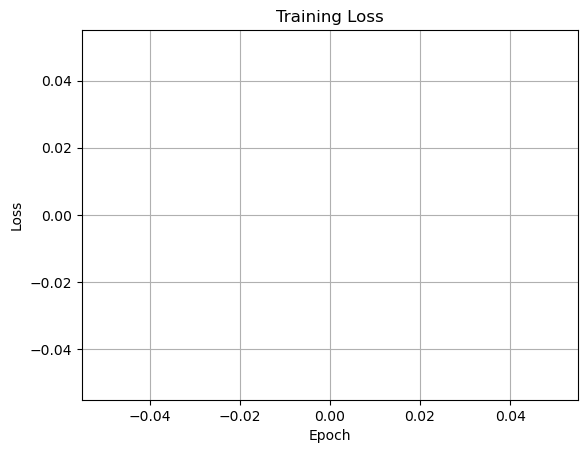

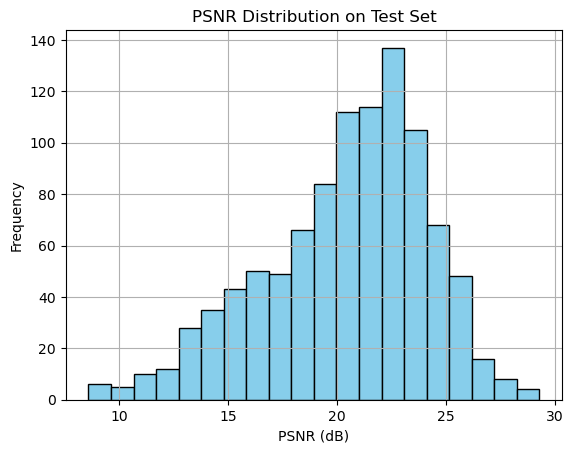

In [10]:
train_and_evaluate()

# Miscellaneous

In [11]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
import torchvision.transforms as transforms


def evaluate_saved_models_on_test_set(
    root_dir='../Data',
    weather_type='haze',
    model_dir='./outputs',
    start_epoch=1,
    end_epoch=5,
    batch_size=8,
    save_plot=True
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    # Load test set
    test_ds = WeatherRestorationDataset(root_dir, weather_type, train=False, transform=transform)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    eval_losses = []

    for epoch in range(start_epoch, end_epoch + 1):
        model = EfficientUNet().to(device)
        model_path = os.path.join(model_dir, f"model_epoch{epoch}.pth")
        if not os.path.exists(model_path):
            print(f"Model file {model_path} not found, skipping...")
            continue

        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()

        total_loss_epoch = 0.0
        num_batches = 0

        with torch.no_grad():
            pbar = tqdm(test_loader, desc=f"Evaluating Epoch {epoch}", unit="batch")
            for inputs, targets in pbar:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = total_loss(outputs, targets)
                total_loss_epoch += loss.item()
                num_batches += 1
                pbar.set_postfix(avg_loss=total_loss_epoch / num_batches)

        avg_loss = total_loss_epoch / num_batches
        print(f"Epoch {epoch} - Test Loss: {avg_loss:.6f}")
        eval_losses.append((epoch, avg_loss))

    # Plot
    if save_plot:
        epochs = [e for e, _ in eval_losses]
        losses = [l for _, l in eval_losses]
        plt.figure(figsize=(8, 5))
        plt.plot(epochs, losses, marker='o')
        plt.title(f"Test Loss per Epoch ({weather_type})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.savefig(os.path.join(model_dir, f"test_loss_curve_{weather_type}.png"))
        plt.show()

    return eval_losses


Using device: cuda


Evaluating Epoch 1: 100%|████████████████████████████████████████| 125/125 [01:02<00:00,  2.01batch/s, avg_loss=0.0855]


Epoch 1 - Test Loss: 0.085518


Evaluating Epoch 2: 100%|████████████████████████████████████████| 125/125 [01:11<00:00,  1.75batch/s, avg_loss=0.0827]


Epoch 2 - Test Loss: 0.082694


Evaluating Epoch 3: 100%|████████████████████████████████████████| 125/125 [01:09<00:00,  1.79batch/s, avg_loss=0.0844]


Epoch 3 - Test Loss: 0.084394


Evaluating Epoch 4: 100%|████████████████████████████████████████| 125/125 [01:14<00:00,  1.69batch/s, avg_loss=0.0814]


Epoch 4 - Test Loss: 0.081377


Evaluating Epoch 5: 100%|█████████████████████████████████████████| 125/125 [01:16<00:00,  1.63batch/s, avg_loss=0.084]


Epoch 5 - Test Loss: 0.084034


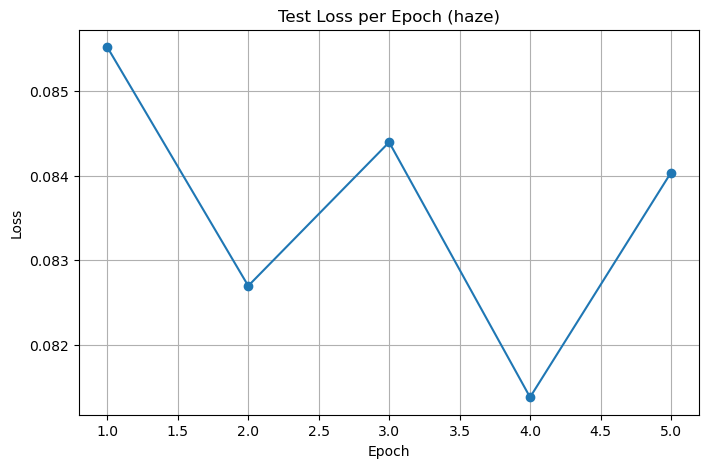

[(1, 0.08551759964227676),
 (2, 0.08269425421953201),
 (3, 0.08439381524920464),
 (4, 0.08137690564990044),
 (5, 0.08403380024433137)]

In [12]:
evaluate_saved_models_on_test_set()

In [5]:
import os
import torch
import torchvision.utils as vutils
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import random

def evaluate_model(root_dir='../Data', weather_type='haze', save_dir='outputs_eval', max_samples=20):
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'samples'), exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    test_ds = WeatherRestorationDataset(root_dir, weather_type, train=False, transform=transform)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

    model = EfficientUNet().to(device)
    model.load_state_dict(torch.load('./outputs/model_epoch5.pth', map_location=device))
    model.eval()

    all_psnr = []
    predictions = []

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Evaluating", unit="img"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            psnr_score = psnr(outputs[0], targets[0])
            all_psnr.append(psnr_score.item())
            predictions.append((inputs.cpu(), outputs.cpu(), targets.cpu()))

    print(f"Avg PSNR: {np.mean(all_psnr):.2f} dB")

    # Save random sample outputs
    sample_indices = random.sample(range(len(predictions)), min(max_samples, len(predictions)))
    for idx, i in enumerate(sample_indices):
        input_img, output_img, target_img = predictions[i]
        comparison = torch.cat([input_img[0], output_img[0], target_img[0]], dim=2)
        vutils.save_image(comparison, os.path.join(save_dir, "samples", f"sample_{idx}.png"), normalize=True)

    # PSNR histogram
    plt.figure()
    plt.hist(all_psnr, bins=20, color='skyblue', edgecolor='black')
    plt.title('PSNR Distribution on Test Set')
    plt.xlabel('PSNR (dB)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.savefig(os.path.join(save_dir, 'psnr_distribution.png'))


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 1000/1000 [01:40<00:00,  9.93img/s]


Avg PSNR: 20.40 dB


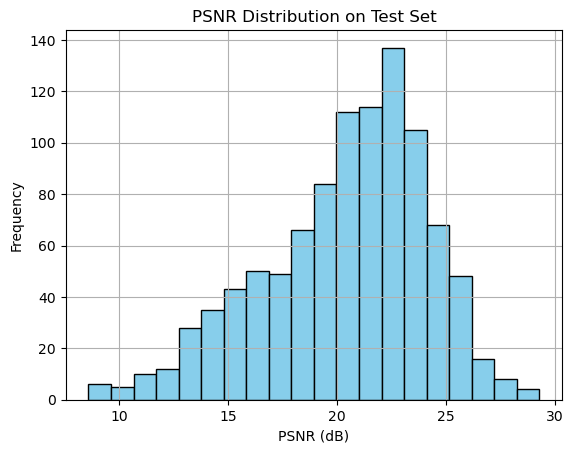

In [6]:
evaluate_model()